## FB15k-237 semantic graph

https://www.kaggle.com/datasets/latebloomer/fb15k-237/data

https://www.kaggle.com/datasets/latebloomer/freebase-wikidata-mapping

In [1]:
# !pip install kagglehub

In [2]:
# import kagglehub

# path = kagglehub.dataset_download("latebloomer/fb15k-237")
# print("Path to dataset files:", path)

In [3]:
import pandas as pd
import numpy as np

In [4]:
data_path = "../datasets/fb15k-237/"

### Load triples and augment from source

### Load augmented triples directly

In [5]:
relations_df = pd.read_csv(f"{data_path}/derived/relations_with_ids.csv")

In [6]:
relations_df.head()

,relation_name,relation_id
0,/location/country/form_of_government,0
1,/tv/tv_program/regular_cast./tv/regular_tv_app...,1
2,/media_common/netflix_genre/titles,2
3,/award/award_winner/awards_won./award/award_ho...,3
4,/soccer/football_team/current_roster./sports/s...,4


In [7]:
freebase_vs_wiki_df =  pd.read_csv(f"{data_path}/fb_wiki_mapping.tsv", sep='\t')
# freebase_vs_wiki_df =  pd.read_csv(f"{data_path}/fb_wiki_mapping.csv")

In [8]:
# freebase_vs_wiki_df[''] = df.index
freebase_vs_wiki_df.head(3)

,freebase_id,wikidata_id,label
0,/m/010005,Q974334,Corinth
1,/m/01000j,Q981582,Draper
2,/m/01000w,Q977417,Cross Roads


In [9]:
freebase_vs_wiki_df.describe()

,freebase_id,wikidata_id,label
count,2096636,2096636,2095837
unique,2094552,2096636,1959699
top,/m/060gfy,Q974334,Central District
freq,3,1,373


In [10]:
# strip Q from wikidata id for easier use with Kumo AI
freebase_vs_wiki_df['wikidata_int_id'] = freebase_vs_wiki_df.apply(lambda row: int(row['wikidata_id'][1:]), axis=1)

In [11]:
freebase_vs_wiki_df.drop('wikidata_id', axis=1, inplace=True)
freebase_vs_wiki_df.rename(columns={'wikidata_int_id':'wikidata_id'}, inplace=True)

In [12]:
triplets_with_src_dst_wiki_ids_df = pd.read_csv(f"{data_path}/exp2/triplets_with_src_dst_wiki_ids.csv")

In [13]:
df_test = pd.read_csv(f"{data_path}/exp2/triplets_with_src_dst_wiki_ids.test.csv")

In [14]:
triplets_with_src_dst_wiki_ids_df['inaccurate'] = triplets_with_src_dst_wiki_ids_df['inaccurate'].astype('bool')
df_test['inaccurate'] = df_test['inaccurate'].astype('bool')

In [15]:
## Reset label for test samples to 
# df_test['inaccurate'] = False
# df_test['inaccurate'] = '0.2'

# df_test.inaccurate.value_counts()

In [16]:
combined_triplets = pd.concat([triplets_with_src_dst_wiki_ids_df, df_test])

In [17]:
# combined_triplets['inaccurate'] = combined_triplets['inaccurate'].astype('float')
combined_triplets[['inaccurate']].value_counts()

inaccurate
False         208993
True           52382
Name: count, dtype: int64

In [18]:
combined_triplets['timestamp'] = pd.to_datetime(combined_triplets['timestamp'])
# combined_triplets['inaccurate'] = combined_triplets['inaccurate'].astype('bool')

In [19]:
# triplets_with_src_dst_wiki_ids_df.info()
combined_triplets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 261375 entries, 0 to 18285
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   src_freebase_id   261375 non-null  object        
 1   relation          261375 non-null  object        
 2   dest_freebase_id  261375 non-null  object        
 3   triple_id         261375 non-null  int64         
 4   timestamp         261375 non-null  datetime64[ns]
 5   relation_name     261375 non-null  object        
 6   relation_id       261375 non-null  int64         
 7   freebase_id_x     261375 non-null  object        
 8   label_x           261375 non-null  object        
 9   src_wikidata_id   261375 non-null  int64         
 10  freebase_id_y     261375 non-null  object        
 11  label_y           261375 non-null  object        
 12  dest_wikidata_id  261375 non-null  int64         
 13  inaccurate        261375 non-null  bool          
dtypes: bool(1)

In [20]:
# Experiment - split labels into a separate table
data_quality_df = combined_triplets[['triple_id', 'inaccurate']].copy()

data_quality_df = triplets_with_src_dst_wiki_ids_df[['triple_id', 'inaccurate']].copy()
data_quality_df['id'] = data_quality_df.index

data_quality_df['inaccurate'] = data_quality_df['inaccurate'].astype('int')

In [41]:
# add random timestamps to force fit into KumoAI restrictions
base_date = pd.Timestamp('2025-02-01')

num_triples = len(data_quality_df)
random_days_ago_integers = np.random.randint(1, 24, size=num_triples)

time_deltas = pd.to_timedelta(random_days_ago_integers, unit='days')

data_quality_df['created_at'] = base_date - time_deltas

In [21]:
# All nodes and associated triples for freebase / wiki ?
import kumoai as kumo

In [22]:
import kumoai.experimental.rfm as rfm
import os

In [23]:
if not os.environ.get("KUMO_API_KEY"):
    rfm.authenticate()

Opening browser page to automatically generate an API key...


[2025-08-20 12:22:58 - kumoai:298 - INFO] Generated token "sdk-macbook-pro-3.local-2025-08-20-12-22-56-Z" and saved to KUMO_API_KEY env variable


In [24]:
KUMO_API_KEY = os.environ.get("KUMO_API_KEY")
rfm.init(api_key=KUMO_API_KEY)

[2025-08-20 12:23:06 - kumoai:196 - INFO] Successfully initialized the Kumo SDK against deployment https://kumorfm.ai/api, with log level INFO.


In [25]:
triples = rfm.LocalTable(
    combined_triplets[['triple_id', 'src_wikidata_id', 'relation_id', 'dest_wikidata_id', 'timestamp']], 
    name="triples"
).infer_metadata()

Detected primary key 'triple_id' and time column 'timestamp' in table 'triples'


In [26]:
relations = rfm.LocalTable(
    relations_df, name="relations", primary_key='relation_id'
).infer_metadata()

In [42]:
data_quality = rfm.LocalTable(
    data_quality_df, name="data_quality"
).infer_metadata()

data_quality.column("inaccurate").stype = "numerical"

Detected primary key 'id' and time column 'created_at' in table 'data_quality'


In [28]:
freebase_vs_wiki1 = rfm.LocalTable(freebase_vs_wiki_df, name="freebase_vs_wiki_src", primary_key="wikidata_id").infer_metadata()

In [29]:
freebase_vs_wiki2 = rfm.LocalTable(freebase_vs_wiki_df.copy(), name="freebase_vs_wiki_dest", primary_key="wikidata_id").infer_metadata()

In [43]:
graph = rfm.LocalGraph(tables=[
    triples,
    relations,
    freebase_vs_wiki1,
    freebase_vs_wiki2,
    data_quality,
])

In [44]:
# graph.link(src_table="freebase_vs_wiki", fkey="src_wikidata_id", dst_table="triples")
graph.link(src_table="triples", fkey="src_wikidata_id", dst_table="freebase_vs_wiki_src")

LocalGraph(
  tables=[triples, relations, freebase_vs_wiki_src, freebase_vs_wiki_dest, data_quality],
  edges=[Edge(src_table='triples', fkey='src_wikidata_id', dst_table='freebase_vs_wiki_src')],
)

In [45]:
graph.link(src_table="data_quality", fkey="triple_id", dst_table="triples")

LocalGraph(
  tables=[triples, relations, freebase_vs_wiki_src, freebase_vs_wiki_dest, data_quality],
  edges=[Edge(src_table='triples', fkey='src_wikidata_id', dst_table='freebase_vs_wiki_src'), Edge(src_table='data_quality', fkey='triple_id', dst_table='triples')],
)

In [46]:
graph.link(src_table="triples",fkey="relation_id", dst_table="relations")

LocalGraph(
  tables=[triples, relations, freebase_vs_wiki_src, freebase_vs_wiki_dest, data_quality],
  edges=[Edge(src_table='triples', fkey='src_wikidata_id', dst_table='freebase_vs_wiki_src'), Edge(src_table='data_quality', fkey='triple_id', dst_table='triples'), Edge(src_table='triples', fkey='relation_id', dst_table='relations')],
)

In [47]:
graph.link(src_table="triples", fkey="dest_wikidata_id", dst_table="freebase_vs_wiki_dest")

LocalGraph(
  tables=[triples, relations, freebase_vs_wiki_src, freebase_vs_wiki_dest, data_quality],
  edges=[Edge(src_table='triples', fkey='src_wikidata_id', dst_table='freebase_vs_wiki_src'), Edge(src_table='data_quality', fkey='triple_id', dst_table='triples'), Edge(src_table='triples', fkey='relation_id', dst_table='relations'), Edge(src_table='triples', fkey='dest_wikidata_id', dst_table='freebase_vs_wiki_dest')],
)

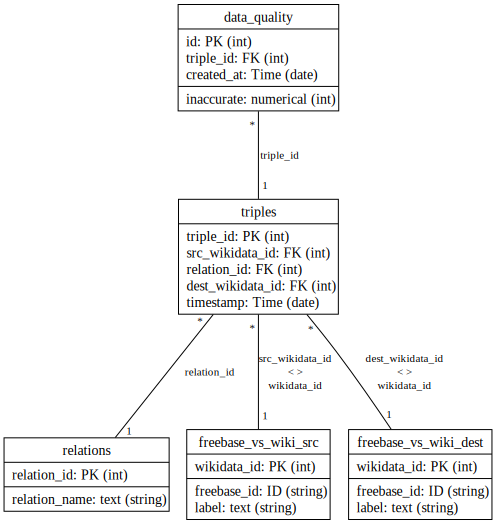

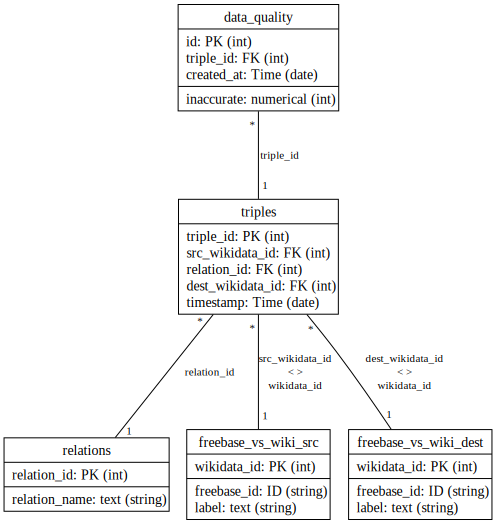

In [48]:
graph.visualize()

In [49]:
# graph['triples']['relation'].stype
# graph['triples']['relation_id'].stype

In [50]:
model = rfm.KumoRFM(graph)

Output()

In [51]:
# PREDICT triples.relation
# Couldn't pick a unique triples.relation for each freebase_vs_wiki. row 1, column 8: Encountered an error, we have found 
# multiple 'relation' values in the 'triples' table for a single 'freebase_vs_wiki'. To fix this, you have two options:
## 1. Aggregate the values: If your 'triples' table has a 'created at' column, use an aggregation function to reduce them to one value. 
##   For example: PREDICT LAST(triples.relation, 0, 30, days).
## 2. Rewrite your query: If you are writing a static node prediction predictive query, make sure that you 
##   either use the same table to define your target and entity, or you have a foreign key from the entity pointing to the target table, 
##   not the other way around.

# PREDICT triples.relation RANK TOP 10
## Problem type 'ProblemType.RANK' is only supported for multicategorical targets. . row 1, column 8: Target 'triples.relation' is 
## not multicategorical. Either drop the problem type ProblemType.RANK OR 
## change the target to a multicategorical column, 'LAST'/'FIRST' aggregation of a multicategorical column, or a 'LIST_DISTINCT' aggregation.

# FOR triples.src_wikidata_id=7413907
# Invalid entity. row 2, column 4: Entity 'triples.src_wikidata_id' is not a primary key. 
# The column used in 'FOR EACH' has to be a primary key.

# FOR 

# WHERE triples.relation contains 'place'


In [52]:
# kumo.init(api_key=KUMO_API_KEY)

In [53]:
# Working queries

query = """
PREDICT freebase_vs_wiki.freebase_id 
FOR freebase_vs_wiki.wikidata_id=7413907 
"""

query = """
PREDICT LIST_DISTINCT(triples.relation_id, 0, 80, days)
FOR freebase_vs_wiki.wikidata_id=486860 
"""

# relations / types of edges for Arnold Schwarzenegger
query = """
PREDICT LIST_DISTINCT(triples.relation_id, 0, 80, days)
FOR freebase_vs_wiki_src.wikidata_id=2685 
"""

query1 = """
PREDICT triples.inaccurate
FOR triples.triple_id =2685 
"""

# FOR triples.triple_id IN (1,2,3,4,168229,155507,15727) 

"""
PREDICT LIST_DISTINCT(triples.relation_id WHERE triples.inaccurate = 1, 0, 80, days)
FOR freebase_vs_wiki_src.wikidata_id=2685  
"""


'\nPREDICT LIST_DISTINCT(triples.relation_id WHERE triples.inaccurate = 1, 0, 80, days)\nFOR freebase_vs_wiki_src.wikidata_id=2685  \n'

In [54]:
# all triples associated with 2685
triple_ids_arnie=triplets_with_src_dst_wiki_ids_df.loc[triplets_with_src_dst_wiki_ids_df['src_wikidata_id']==2685].triple_id.to_list()

In [55]:
triple_ids_arnie_str = f"{triple_ids_arnie}"
triple_ids_arnie_str = triple_ids_arnie_str.replace("[","(").replace("]",")")

In [56]:
query1 = """
PREDICT data_quality.inaccurate
FOR triples.triple_id IN """ + triple_ids_arnie_str

In [57]:
# triples with label 1 / inaccurate facts from test set
probe_triplet_ids_errors=df_test.loc[df_test['inaccurate']==True].sample(100).triple_id.to_list()
probe_triplet_ids_non_errors=df_test.loc[df_test['inaccurate']==False].sample(100).triple_id.to_list()

probe_triplet_ids_str = f"{probe_triplet_ids_errors}"
probe_triplet_ids_str = probe_triplet_ids_str.replace("[","(").replace("]",")")

In [58]:
probe_triplet_ids_str = f"{probe_triplet_ids_errors}"
probe_triplet_ids_str = probe_triplet_ids_str.replace("[","(").replace("]",")")
# print(probe_triplet_ids_str)

query1 = """
PREDICT AVG(data_quality.inaccurate, 0, 80, days)
FOR triples.triple_id IN """ + probe_triplet_ids_str

pred1_df = model.predict(query1)

probe_triplet_ids_str = f"{probe_triplet_ids_non_errors}"
probe_triplet_ids_str = probe_triplet_ids_str.replace("[","(").replace("]",")")
query2 = """
PREDICT AVG(data_quality.inaccurate, 0, 80, days)
FOR triples.triple_id IN """ + probe_triplet_ids_str

pred2_df = model.predict(query2)

/Users/ravid/miniconda3/envs/kumo-hackathon-py311/lib/python3.11/site-packages/kumoai/experimental/rfm/rfm.py:360: 
UserWarning: Anchor timestamp is too early or aggregation time range is too large. To form proper input data, we 
would need data back to '2024-08-24 00:00:00', however, your data only contains data back to '2024-10-04 00:00:00'.
  warnings.warn(f"Anchor timestamp is too early or aggregation "

Output()

/Users/ravid/miniconda3/envs/kumo-hackathon-py311/lib/python3.11/site-packages/kumoai/experimental/rfm/rfm.py:360: 
UserWarning: Anchor timestamp is too early or aggregation time range is too large. To form proper input data, we 
would need data back to '2024-08-24 00:00:00', however, your data only contains data back to '2024-10-04 00:00:00'.
  warnings.warn(f"Anchor timestamp is too early or aggregation "

Output()

In [59]:
# display(pred1_df)
pred1_df.describe()

,ENTITY,ANCHOR_TIMESTAMP,TARGET_PRED
count,100.000000,1.000000e+02,100.000000
mean,281685.110000,1.738282e+12,0.078337
std,4907.324066,0.000000e+00,0.005893
min,272191.000000,1.738282e+12,0.069608
25%,277585.000000,1.738282e+12,0.074231
50%,282033.000000,1.738282e+12,0.077324
75%,286022.000000,1.738282e+12,0.080427
max,290336.000000,1.738282e+12,0.096710


In [60]:
print(pred1_df.TARGET_PRED.describe())

print(pred2_df.TARGET_PRED.describe())

count    100.000000
mean       0.078337
std        0.005893
min        0.069608
25%        0.074231
50%        0.077324
75%        0.080427
max        0.096710
Name: TARGET_PRED, dtype: float64
count    100.000000
mean       0.077905
std        0.005926
min        0.065392
25%        0.074271
50%        0.076676
75%        0.080550
max        0.094684
Name: TARGET_PRED, dtype: float64


In [ ]:
# plot(pred1_df.TARGET_PRED)

In [ ]:
# pred1_df.loc[pred1_df['PREDICTED']==False].sort_values(by='SCORE', ascending=False)
pred1_df.sort_values(by='TARGET_PRED', ascending=False)

In [ ]:
triplets_with_src_dst_wiki_ids_df[triplets_with_src_dst_wiki_ids_df['inaccurate']==1].head(15) 

pquery_relations_for_entity = kumo.PredictiveQuery(
	graph=graph,
	query=query
)

pquery_relations_for_entity.validate()

In [ ]:
graph._to_api_graph_definition()

In [ ]:
# Running examples
# all relations with src_wikidata_id 
## 7413907 / Q7413907 , San Francisco
## 486860 , Mountain View
## 2685, Arnold Schwarzenegger


triplets_with_src_dst_wiki_ids_df.loc[triplets_with_src_dst_wiki_ids_df['src_wikidata_id']==2685].to_csv(
    "~/Downloads/arnold_schwarzenegger_outgoing_edges.csv", index=False
)


In [ ]:
## Arnold Schwarznegger

# 6 -> /film/actor/film./film/performance/film
# 38 -> nomination
# 

In [ ]:
df44 = triplets_with_src_dst_wiki_ids_df[['src_freebase_id', 'src_wikidata_id', 'label_x']].drop_duplicates()
# df44.to_csv('~/Downloads/triples_train_src_entities.csv', index=False)

## Yago semantic graph 
Usecase - find inconsistencies / anomalies in knowledge graphs